In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from importlib import reload
from mppi import InputFiles as I, Calculators as C, Datasets as D

# Tutorial for the Dataset module

The main object to deal with (one or several) calculations is the Dataset class. Here we discuss some explicit examples to describe the usage and the main features of the package.

## Perform a convergence analysis for the gs energy of Silicon

We discuss how to perform a convergence analysis for the determination of the number of k-points and the cut-off energy that provides _converged_ results for the gs of Silicon using QE.

Define the dataset and specify the type of pre_processing function

In [2]:
si_gs = D.Dataset(label='Si gs convergence',run_dir='si_gs',pre_processing='scf')

Define the calculator that will execute the computations

In [3]:
code = C.QeCalculator(omp=1,mpi_run='mpirun -np 4',executable='pw.x',verbose=True,skip=True)

Initialize a qe calculator with command OMP_NUM_THREADS=1 mpirun -np 4 pw.x


Call the pre_processing function, that in this case build the run_dir if it is not already present

In [4]:
si_gs.pre_processing_function()

Create folder si_gs


Append the runs to the dataset. This procedures make usage of the PwIn boject that creates the instance of the input for QE. The object are written on file only at the level of the run

In [5]:
si_input = I.PwIn()
A = [0.125,0.125,0.125]
B = [-.125,-.125,-.125]

si_input.set_pseudo_dir('../pseudos')
si_input.set_calculation('scf')
si_input.system['force_symmorphic'] = ".true."

si_input.set_occupations('fixed')
si_input.system['ibrav'] = 2
si_input.system['celldm(1)'] = 10.3
si_input.set_atoms_type(1)
si_input.set_atoms_number(2)
si_input.set_atoms_position(pos_type='crystal',pos_list=[['Si',A],['Si',B]])
si_input.atypes = {'Si': [28.086,"Si.pbe-mt_fhi.UPF"]}
si_input.set_convergence_thr(1e-8)

print(si_input)

&control
           verbosity = 'high'
          pseudo_dir = '../pseudos'
         calculation = 'scf'
/&end
&system
    force_symmorphic = .true.
         occupations = 'fixed'
               ibrav = 2
           celldm(1) = 10.3
                ntyp = 1
                 nat = 2
/&end
&electrons
            conv_thr = 1e-08
/&end
ATOMIC_SPECIES
  Si   28.086    Si.pbe-mt_fhi.UPF
ATOMIC_POSITIONS { crystal }
 Si   0.1250000000   0.1250000000   0.1250000000
 Si  -0.1250000000  -0.1250000000  -0.1250000000
K_POINTS { automatic }
  1  1  1  0  0  0



Choose the parameters for the convergence test and append the associated runs

In [6]:
kpoints = [2,3,4,5,6] 
ecut = [10,20,30,40,50]

In [7]:
for k in kpoints:
    for e in ecut:
        idd = {'k' : k, 'ecut' : e} 
        si_input.set_prefix(D.name_from_id(idd))
        si_input.set_kpoints(ktype='automatic',kpoints=[k,k,k])
        si_input.set_energy_cutoff(e)
        si_gs.append_run(id=idd,calculator=code,input=si_input)

In [8]:
print(si_gs.runs[5])

&control
           verbosity = 'high'
          pseudo_dir = '../pseudos'
         calculation = 'scf'
              prefix = 'ecut_10-k_3'
/&end
&system
    force_symmorphic = .true.
         occupations = 'fixed'
               ibrav = 2
           celldm(1) = 10.3
                ntyp = 1
                 nat = 2
             ecutwfc = 10
/&end
&electrons
            conv_thr = 1e-08
/&end
ATOMIC_SPECIES
  Si   28.086    Si.pbe-mt_fhi.UPF
ATOMIC_POSITIONS { crystal }
 Si   0.1250000000   0.1250000000   0.1250000000
 Si  -0.1250000000  -0.1250000000  -0.1250000000
K_POINTS { automatic }
  3  3  3  0  0  0



Note tha the prefix associated to each run is built by means of the name_from_id method that create a string from the idd dictionary of the run. This choice is not mandatory but it is an easy way to have a clear association among the runs and the associated names.

The dataset is run as follows:

In [9]:
si_gs.run(post_processing=True)

execute : cd si_gs ; OMP_NUM_THREADS=1 mpirun -np 4 pw.x -inp ecut_10-k_2.in > ecut_10-k_2.log
parse file : si_gs/ecut_10-k_2.save/data-file-schema.xml
execute : cd si_gs ; OMP_NUM_THREADS=1 mpirun -np 4 pw.x -inp ecut_20-k_2.in > ecut_20-k_2.log
parse file : si_gs/ecut_20-k_2.save/data-file-schema.xml
execute : cd si_gs ; OMP_NUM_THREADS=1 mpirun -np 4 pw.x -inp ecut_30-k_2.in > ecut_30-k_2.log
parse file : si_gs/ecut_30-k_2.save/data-file-schema.xml
execute : cd si_gs ; OMP_NUM_THREADS=1 mpirun -np 4 pw.x -inp ecut_40-k_2.in > ecut_40-k_2.log
parse file : si_gs/ecut_40-k_2.save/data-file-schema.xml
execute : cd si_gs ; OMP_NUM_THREADS=1 mpirun -np 4 pw.x -inp ecut_50-k_2.in > ecut_50-k_2.log
parse file : si_gs/ecut_50-k_2.save/data-file-schema.xml
execute : cd si_gs ; OMP_NUM_THREADS=1 mpirun -np 4 pw.x -inp ecut_10-k_3.in > ecut_10-k_3.log
parse file : si_gs/ecut_10-k_3.save/data-file-schema.xml
execute : cd si_gs ; OMP_NUM_THREADS=1 mpirun -np 4 pw.x -inp ecut_20-k_3.in > ecut_20-k

Results can be easily estracted using the fetch_results method of the dataset

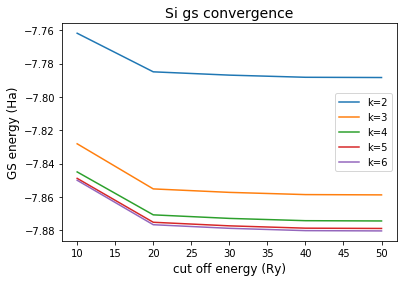

In [10]:
for k in kpoints:
    data=si_gs.fetch_results(id={'k': k},attribute='E_tot')
    plt.plot(ecut,data,label='k='+str(k))
plt.title(si_gs.label,size = 14)
plt.xlabel('cut off energy (Ry)',size=12)
plt.ylabel('GS energy (Ha)',size = 12)
plt.legend()
plt.show()

On the basis of this analysis with identify the scf converged parameters that will be used as input for nscf ones

In [11]:
k_conv = 4
ecut_conv = 50

All the results are written in the .results member of the dataset. This is a dictionary in wich all the post_processing are stored, the key represent the position of the study specified in the .ids list. For instance

In [24]:
si_gs.results[0]

In [25]:
si_gs.ids[0]

{'k': 2, 'ecut': 10}

The method fetch_results (without attribute) gives the instance(s) of the runs that satisfy the requirement passed in the id. Otherwise we can access directly to the dictionary as si_gs.results[key]

A lot of quantities can be extracted from results, for instance

In [26]:
result = si_gs.results[0]

In [27]:
result.E_tot #total energy in Hartree

-7.761788836295096

In [28]:
result.alat #atomic units = angstrom/0.529177211

10.3

In [29]:
result.atoms_coord_cart # in which units ?????

array([[-1.2875,  1.2875,  1.2875],
       [ 1.2875, -1.2875, -1.2875]])

No handles with labels found to put in legend.


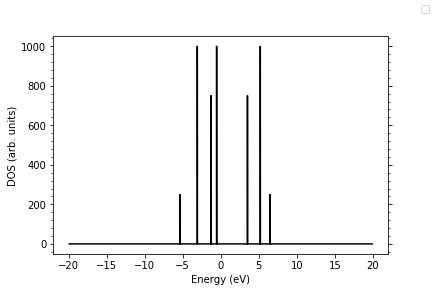

array([[-20.   ,   0.   ],
       [-19.999,   0.   ],
       [-19.998,   0.   ],
       ...,
       [ 19.998,   0.   ],
       [ 19.999,   0.   ],
       [ 20.   ,   0.   ]])

In [30]:
#pFile : option to enable/disable file save
#fname : output file name
result.density_of_states(pFile=False)

## Perform a sef of nscf computations for Silicon

We illustrate the usage of the dataset class to perform nscf computations using QE. In this case the pre_processing function performs different operations since the .save folder of the scf computation used as input has to be copied in the run_dir of the nscf dataset. 

In [35]:
si_nscf = D.Dataset(label='Si nscf',run_dir='si_nscf',pre_processing='nscf')

Define the calculator that will execute the computations

In [36]:
code = C.QeCalculator(omp=1,mpi_run='mpirun -np 4',executable='pw.x',verbose=True,skip=False)

Initialize a qe calculator with command OMP_NUM_THREADS=1 mpirun -np 4 pw.x


Add some runs to the nscf dataset

In [37]:
nscf_kpoints = [4,5,6]

In [38]:
si_input.set_calculation('nscf')
si_input.set_num_bands(10)

for k in nscf_kpoints:
    idd = {'k' : k} 
    si_input.set_prefix(D.name_from_id(idd))
    si_input.set_kpoints(ktype='automatic',kpoints=[k,k,k])
    si_input.set_energy_cutoff(ecut_conv)
    si_nscf.append_run(id=idd,calculator=code,input=si_input)

In [39]:
si_nscf.ids

[{'k': 4}, {'k': 5}, {'k': 6}]

Call the pre_processing function

In [40]:
si_nscf.pre_processing_function(source_dir='si_gs/ecut_50-k_4.save/')

Create folder si_nscf
execute :  cp -r si_gs/ecut_50-k_4.save/ si_nscf/k_4.save
execute :  cp -r si_gs/ecut_50-k_4.save/ si_nscf/k_5.save
execute :  cp -r si_gs/ecut_50-k_4.save/ si_nscf/k_6.save


Now the dataset can be run and the post_processing parse the output as in the scf case

In [41]:
si_nscf.run()

execute : cd si_nscf ; OMP_NUM_THREADS=1 mpirun -np 4 pw.x -inp k_4.in > k_4.log
parse file : si_nscf/k_4.save/data-file-schema.xml
execute : cd si_nscf ; OMP_NUM_THREADS=1 mpirun -np 4 pw.x -inp k_5.in > k_5.log
parse file : si_nscf/k_5.save/data-file-schema.xml
execute : cd si_nscf ; OMP_NUM_THREADS=1 mpirun -np 4 pw.x -inp k_6.in > k_6.log
parse file : si_nscf/k_6.save/data-file-schema.xml


## Perform a set of Hartree-Fock computations with Yambo

Dataset can be used to organize Yambo computation in an analogous way of the QE ones. The differences are represented by the usage of YamboIn to build the input files, the usage of YamboCalculator to run the computations and by the pre_processing function.

In [42]:
code = C.YamboCalculator(omp=1,mpi_run='mpirun -np 4',executable='yambo',suffix='hf',verbose=True,skip=True)

Initialize a Yambo calculator with command OMP_NUM_THREADS=1 mpirun -np 4 yambo
Suffix for post_processing :  hf


In [43]:
yambo_hf = D.Dataset(label='Hatree-Fock',run_dir='yambo_hf',pre_processing='yambo')

In this case the pre_processing function _has to be_ called before appending the runs because the YamboIn class neeeds the SAVE folder to init the input object.

The dataset make usage of __one__ nscf computation to build the SAVE folder that is used in all the runs

In [44]:
source = 'si_nscf/k_6.save/'

In [45]:
yambo_hf.pre_processing_function(source_dir=source)

Create folder yambo_hf
execute :  cd si_nscf/k_6.save/;p2y -a 2
execute :  cp -r si_nscf/k_6.save//SAVE yambo_hf
execute :  cd yambo_hf;OMP_NUM_THREADS=1 yambo


Now the runs can be appended to the dataset. For instance we perform parametric runs in terms of the EXXRLvcs parameter that expresses the energy cutoff in the number of g-components of G0

In [46]:
exx_values = [2.,3.,4.] #in Hartree

In [47]:
yambo_in = I.YamboIn('yambo -x -V rl',folder=yambo_hf.run_dir)

for ex in exx_values:
    idd = {'EXXRLvcs' : ex} 
    yambo_in['EXXRLvcs'] = [1000.0*ex,'mHa']
    yambo_hf.append_run(id=idd,calculator=code,input=yambo_in)  

In [48]:
yambo_hf.ids

[{'EXXRLvcs': 2.0}, {'EXXRLvcs': 3.0}, {'EXXRLvcs': 4.0}]

In [51]:
print(yambo_hf.runs[0])

HF_and_locXC
FFTGvecs = 2133.000000 RL
SE_Threads = 0.000000e+00 
EXXRLvcs = 2000.000000 mHa
% QPkrange
 1 | 32 | 1 | 10 |   
%



In [52]:
yambo_hf.run()

execute : cd yambo_hf ; OMP_NUM_THREADS=1 mpirun -np 4 yambo -F EXXRLvcs_2.0.in -J EXXRLvcs_2.0 -C EXXRLvcs_2.0
parse file : yambo_hf/EXXRLvcs_2.0/o-EXXRLvcs_2.0.hf
execute : cd yambo_hf ; OMP_NUM_THREADS=1 mpirun -np 4 yambo -F EXXRLvcs_3.0.in -J EXXRLvcs_3.0 -C EXXRLvcs_3.0
parse file : yambo_hf/EXXRLvcs_3.0/o-EXXRLvcs_3.0.hf
execute : cd yambo_hf ; OMP_NUM_THREADS=1 mpirun -np 4 yambo -F EXXRLvcs_4.0.in -J EXXRLvcs_4.0 -C EXXRLvcs_4.0
parse file : yambo_hf/EXXRLvcs_4.0/o-EXXRLvcs_4.0.hf


Results can be extraced in various ways, both using the fetch_results methods or by direct access to the attribute of the Yambo parser. Here we provide some examples.

First of all we can see the names of the attributes for each elements of yambo_hf.results as follows

In [53]:
keys = yambo_hf.results[0].getAttributes()
print(keys)

dict_keys(['K-point', 'Band', 'Eo', 'Ehf', 'DFT', 'HF'])


Then, we can access to the values directly as

In [54]:
yambo_hf.results[0].Ehf[0:5]

[-18.69873, -1.207, -1.438, -0.62819, 6.98599]

Or by using the fetch_results

In [55]:
yambo_hf.fetch_results(id={'EXXRLvcs' : 2.0},attribute='Ehf')[0][0:5]

[-18.69873, -1.207, -1.438, -0.62819, 6.98599]

Also we can use fetch_results to extract the computation(s) that we need and then access directly to the attributes

In [56]:
yambo_hf.fetch_results(id={'EXXRLvcs' : 2.0})[0].Ehf[0:5]

[-18.69873, -1.207, -1.438, -0.62819, 6.98599]